## SVD

In [15]:
import os
import itertools
from sklearn.utils import shuffle
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as d
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.modules as mod
import torch.utils.data
import torch.utils.data as data
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence
from torch.autograd import Variable
import numpy as np
import sys
import importlib
import time
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image
import librosa
from scipy import signal
from scipy import stats
from scipy.special import comb
import matplotlib.pyplot as plt
import glob
import pickle
from random import randint, choice
import random
global GPU
GPU = 0
plt.style.use('default')
device = torch.device('cuda:0')
print('Torch version =', torch.__version__, 'CUDA version =', torch.version.cuda)
print('CUDA Device:', device)
print('Is cuda available? =',torch.cuda.is_available())

Torch version = 1.6.0 CUDA version = 10.2
CUDA Device: cuda:0
Is cuda available? = True


In [16]:
#%matplotlib notebook
# %matplotlib inline

#### Machine paths

In [17]:
path = "/home/david/sigMF_ML/SVD/" # ACE
path_save = "/home/david/sigMF_ML/SVD/svd_plots" # ACE
path_save2 = "/home/david/sigMF_ML/SVD/clean_speech/IQ_files/stoi_save/" # ace
print(path)

/home/david/sigMF_ML/SVD/


In [18]:
os.chdir(path)
db = np.fromfile("UHF_UV5R_V2_plus_voice__snr_hi.sigmf-data", dtype="float32")

In [19]:
n=2
I = db[0::2]
Q = db[1::2]

In [20]:
from timeit import default_timer as timer

### scipy method

In [21]:
n_fft = 1024
t = len(db)
max = 5000000
db2 = db[0::]
start = timer()
db2 = db2.astype(np.float32).view(np.complex64)
Fs = 1e6
I_t, I_f, Z = signal.stft(db2, fs=Fs, nperseg=n_fft, return_onesided=False)
ps = np.abs(Z)
IQ2 = np.vstack([ps[n_fft//2:], ps[:n_fft//2]])
end = timer()
print(end - start)

0.2951801199997135


### SVD

In [22]:
U, D, V = np.linalg.svd(IQ2[:,:]) 

In [23]:
U.shape, D.shape, V.shape, IQ2.shape

((1024, 1024), (1024,), (9767, 9767), (1024, 9767))

In [24]:
def RelativeError(A, k, U, D, V):
    A_k = np.matrix(U[:, :k]) * np.diag(D[:k]) * V[:k, :10000]
    Ak_norm = np.linalg.norm(A_k, ord=None)
#     print('Ak norm = ', Ak_norm)
    A_norm = np.linalg.norm(A, ord=None)
#     print('A_norm = ', A_norm)
    AK = np.linalg.norm((A-A_k), ord=None)
    error = AK/A_norm*100
    return error

### Trying to match up vectors...

In [25]:
rank = np.size(IQ2[:,:10000],1)
rank

9767

In [26]:
start = timer()
rank = np.size(IQ2[:,:10000],1)
err = np.zeros(rank) # for starting at index position 1
for k in range(1,999):
    err[k] = RelativeError(IQ2[:1024,:9767], k, U, D, V)
end = timer()
print(end - start)    

142.90126940900063


In [27]:
# os.chdir(path_save)
# np.save('lora_err', err)

In [28]:
os.chdir(path_save)
lora_err = np.load('lora_err.npy')
click_err = np.load('click_err.npy')
ptt_err = np.load('ptt_err.npy')
vod_err = np.load('vod_err.npy')
ysf_err = np.load('ysf_err.npy')
tyt_err = np.load('tyt_err.npy')

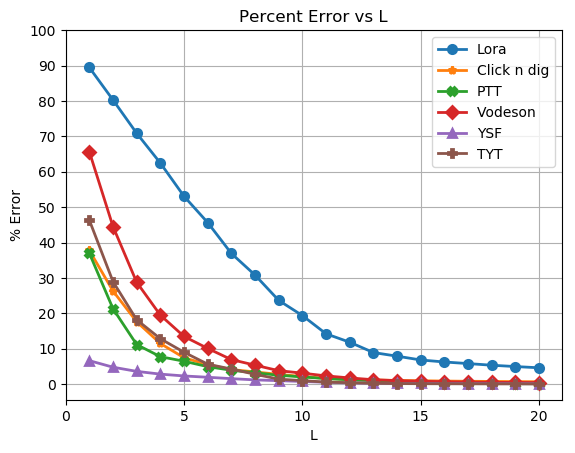

In [29]:
rank = np.size(IQ2,1)
rank = 21 # reduced rank by 1 for matrix math to work out
x = np.arange(0,rank,1) # Start at index position 1
f = np.argmin(err[1:rank]<1.0)
plt.figure(figsize=(9, 6))
fig2 = plt.figure()
plt.plot(x[1:rank],lora_err[1:rank], '-o', c='#1f77b4',markersize=6, linewidth=2,markerfacecolor='#1f77b4',markeredgecolor='#1f77b4',markeredgewidth=2,label='Lora')
plt.plot(x[1:rank],click_err[1:rank], '-*', c='#ff7f0e',markersize=6, linewidth=2,markerfacecolor='#ff7f0e',markeredgecolor='#ff7f0e',markeredgewidth=2, label='Click n dig')
plt.plot(x[1:rank],ptt_err[1:rank], '-X', c='#2ca02c', markersize=6, linewidth=2,markerfacecolor='#2ca02c',markeredgecolor='#2ca02c',markeredgewidth=2, label='PTT')
plt.plot(x[1:rank],vod_err[1:rank], '-D', c='#d62728', markersize=6, linewidth=2,markerfacecolor='#d62728',markeredgecolor='#d62728',markeredgewidth=2, label='Vodeson')
plt.plot(x[1:rank],ysf_err[1:rank], '-^', c='#9467bd', markersize=6, linewidth=2,markerfacecolor='#9467bd',markeredgecolor='#9467bd',markeredgewidth=2, label='YSF')
plt.plot(x[1:rank],tyt_err[1:rank], '-P', c='#8c564b', markersize=6, linewidth=2,markerfacecolor='#8c564b',markeredgecolor='#8c564b',markeredgewidth=2, label='TYT')
plt.legend(loc='upper right')
plt.title('Percent Error vs L')
plt.xlabel('L')
plt.ylabel('% Error')
plt.grid()
# plt.minorticks_on()
plt.yticks(np.arange(0,110, 10))
plt.xticks([0, 5, 10, 15, 20])
fig2.savefig('all_err_plots20.pdf', format="pdf")
plt.show()

In [30]:
os.chdir(path_save2)
dmr = np.load('dmr.npy')
uv5r = np.load('uv5r.npy')
rank_list_uv5r = np.load('rank_list_uv5r.npy')
rank_list_dmr = np.load('rank_list_dmr.npy')

In [31]:
dmr.shape, rank_list_dmr.shape, uv5r.shape, rank_list_uv5r.shape

((6,), (6,), (9,), (9,))

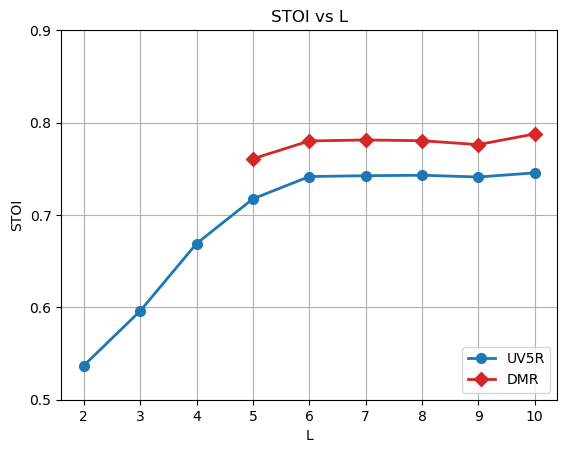

In [32]:
os.chdir(path_save)
rank1 = 9 # reduced rank by 1 for matrix math to work out
rank2 = 6 # reduced rank by 1 for matrix math to work out
plt.figure(figsize=(9, 6))
fig3 = plt.figure()
plt.plot(rank_list_uv5r[0:rank1],uv5r[0:rank1], '-o', c='#1f77b4',markersize=6, linewidth=2,markerfacecolor='#1f77b4',markeredgecolor='#1f77b4',markeredgewidth=2,label='UV5R')
plt.plot(rank_list_dmr[0:rank2],dmr[0:rank2], '-D', c='#d62728',markersize=6, linewidth=2,markerfacecolor='#d62728',markeredgecolor='#d62728',markeredgewidth=2, label='DMR')
plt.legend(loc='lower right')
plt.title('STOI vs L')
plt.xlabel('L')
plt.ylabel('STOI')
plt.grid()
# plt.minorticks_on()
plt.yticks(np.arange(.5,.901, .1))
plt.xticks(np.arange(2,11, 1))
fig3.savefig('stoi_all.pdf', format="pdf")
plt.show()

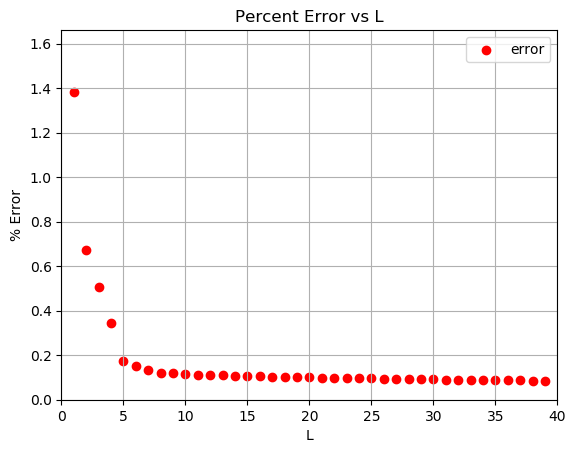

In [33]:
os.chdir(path_save)
rank = np.size(IQ2,1)
rank = 40 # reduced rank by 1 for matrix math to work out
x = np.arange(rank+1) # Start at index position 1
f = np.argmin(err[1:rank]<1.0)
plt.figure(figsize=(9, 6))
fig2 = plt.figure()
plt.scatter(x[1:rank],err[1:rank],c='r', label='error')
plt.legend(loc='upper right')
plt.title('Percent Error vs L')
plt.xlabel('L')
plt.ylabel('% Error')
plt.ylim([0, np.amax(err)+np.amax(err)*.2])
plt.xlim(0, rank)
plt.grid()
fig2.savefig('UV5R_1MSPS_40vectors.png', format="png")
plt.show()
end = timer()

### Find the first Ak when the realative error is less than 1%

In [34]:
err2 = err[1:-1]
h = np.argmax(err2<1.00)
print('Error less than 1% is', err2[h], 'at position', h, 'in the matrix.')

Error less than 1% is 0.6729873828589916 at position 1 in the matrix.


In [35]:
h = 29
print('Error at specific vector count', err2[h], 'at position', h, 'in the matrix.')

Error at specific vector count 0.09136456646956503 at position 29 in the matrix.


In [36]:
rank = np.linalg.matrix_rank(IQ2[:,1400:2500], tol=None)
print('The rank is', rank)

The rank is 23


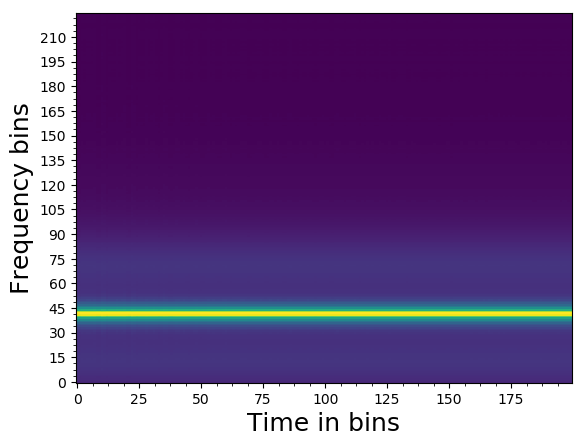

In [39]:
h = 2 # new value to plot to
Ak = np.matrix(U[:, :h]) * np.diag(D[:h]) * np.matrix(V[:h, :])
plt.figure(figsize=(9, 6))
fig3 = plt.figure()
# plt.imshow(20*np.log10(np.abs(Ak)+1e-8), aspect='auto', origin='lower')
plt.imshow(20*np.log10(np.abs(Ak[675:900,1500:1700])+1e-8), aspect='auto', origin='lower')
# title = "UDV Vectors: k = %s" % h
# plt.title(title)
plt.xlabel('Time in bins', fontsize=18)
plt.ylabel('Frequency bins', fontsize=18)
plt.minorticks_on()
plt.yticks(np.arange(0,225, 15))
fig3.savefig('UV5R_2.pdf', format="pdf")
plt.show()

#### Plot full reconstruction using full rank

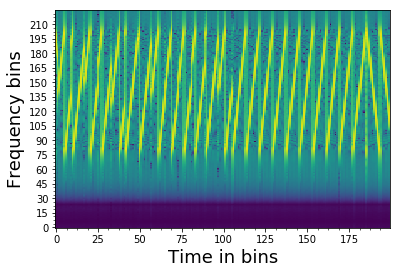

In [65]:
h = 30 # new value to plot to
Ak = np.matrix(U[:, :h]) * np.diag(D[:h]) * np.matrix(V[:h, :])
plt.figure(figsize=(9, 6))
fig3 = plt.figure()
# plt.imshow(20*np.log10(np.abs(Ak)+1e-8), aspect='auto', origin='lower')
plt.imshow(20*np.log10(np.abs(Ak[675:900,1500:1700])+1e-8), aspect='auto', origin='lower')
# title = "UDV Vectors: k = %s" % h
# plt.title(title)
plt.xlabel('Time in bins', fontsize=18)
plt.ylabel('Frequency bins', fontsize=18)
plt.minorticks_on()
plt.yticks(np.arange(0,225, 15))
fig3.savefig('lora_30vectors.pdf', format="pdf")
plt.show()

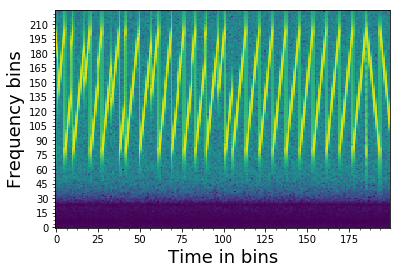

In [66]:
h = 1024 # new value to plot to
Ak = np.matrix(U[:, :h]) * np.diag(D[:h]) * np.matrix(V[:h, :])
plt.figure(figsize=(9, 6))
fig3 = plt.figure()
# plt.imshow(20*np.log10(np.abs(Ak)+1e-8), aspect='auto', origin='lower')
plt.imshow(20*np.log10(np.abs(Ak[675:900,1500:1700])+1e-8), aspect='auto', origin='lower')
# title = "UDV Vectors: k = %s" % h
# plt.title(title)
plt.xlabel('Time in bins', fontsize=18)
plt.ylabel('Frequency bins', fontsize=18)
plt.minorticks_on()
plt.yticks(np.arange(0,225, 15))
fig3.savefig('lora_1024vectors.pdf', format="pdf")
plt.show()